In [1]:
%run imu.ipynb

loading cache_data.pkl
loading cache_WISDM.pkl


In [2]:
dfs

[                               1         2         3         4
 0                                                             
 2013-06-06 12:07:49.550  Walking  0.294132 -0.635605 -0.226936
 2013-06-06 12:07:49.600  Walking -0.499688 -0.604451 -0.226020
 2013-06-06 12:07:49.650  Walking -2.178345  0.713491  0.372017
 2013-06-06 12:07:49.700  Walking -2.797763  1.354899 -0.277638
 2013-06-06 12:07:49.750  Walking -2.167961 -1.327716 -0.554971
 ...                          ...       ...       ...       ...
 2013-06-06 12:08:39.500  Walking -1.808772  1.565953  1.091922
 2013-06-06 12:08:39.550  Walking -0.178678  1.257772  1.084286
 2013-06-06 12:08:39.600  Walking  0.866818  0.437379  0.545808
 2013-06-06 12:08:39.650  Walking  1.812132 -1.011593  0.136834
 2013-06-06 12:08:39.700  Walking  0.982577  0.458760 -0.175013
 
 [1004 rows x 4 columns],
                                1         2      3         4
 0                                                          
 2008-01-10 21:20:

In [3]:
%run imu_unlabeled.ipynb

unlabeled/* already exists
unlabeled_df/* already exists


In [4]:
preview('0.pkl')

[(1377283015208, 'NoLabel', 0.06810174, -0.027240695, 9.833891), (1377283015258, 'NoLabel', 0.10896278, -0.06810174, 9.997335), (1377283015308, 'NoLabel', 0.10896278, -0.14982383, 9.997335), (1377283015358, 'NoLabel', 0.06810174, -0.027240695, 10.147159), (1377283015408, 'NoLabel', 0.06810174, -0.14982383, 10.065437), (1377283015458, 'NoLabel', 0.06810174, -0.06810174, 9.915613), (1377283015508, 'NoLabel', 0.027240695, -0.06810174, 9.915613), (1377283015558, 'NoLabel', 0.027240695, -0.06810174, 9.997335), (1377283015608, 'NoLabel', 0.027240695, -0.027240695, 9.997335), (1377283015658, 'NoLabel', 0.027240695, -0.06810174, 10.024576)]
                                     0        1         2         3          4
0                                                                             
2013-08-23 18:36:55.200  1377283015208  NoLabel  0.068102 -0.027241   9.833891
2013-08-23 18:36:55.250  1377283015258  NoLabel  0.108963 -0.068102   9.997335
2013-08-23 18:36:55.300  1377283015308  NoL

In [5]:
time_step = 64 # 1 sec, 20Hz sampling rate
channels = 3
input_shape = (time_step, channels)

In [6]:
def load_df(path):
    with open(path, 'rb') as file:
        series = pickle.load(file)
    return series

In [7]:
def rolling_window(a, window, strides=0):
    windows = []
    for i in range(0, len(a), strides):
        start = i
        end = i + window
        if end > len(a):
            end = len(a)
            start = end - window
        windows.append(np.asarray(a[start:end]))
    return windows

In [8]:
def df_to_windows(df):
    arr = df[[2, 3, 4]].to_numpy()
    #print(df)
    windows = rolling_window(arr, time_step, time_step)
    #print(windows[-1])
    return windows

In [9]:
def traversal(dirpath):
    for fname in os.listdir(dirpath):
        df = load_df(os.path.join(dirpath, fname))
        df_to_windows(df)
        break
        
traversal('unlabeled_df')

In [249]:
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, BatchNormalization, GlobalAveragePooling1D

In [11]:
def data_generator(dirpath):
    fnames = os.listdir(dirpath)
    #print(len(fnames), fnames[:10], '...')
    for fname in fnames:
        df = load_df(os.path.join(dirpath, fname))
        if len(df) < time_step:
            continue
        winds = df_to_windows(df)
        for wind in winds:
            yield wind
        #print(winds[0])
        #return

In [12]:
gen = data_generator('unlabeled_df')

In [13]:
next(gen).shape

(64, 3)

In [63]:
class Autoencoder(Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape, dtype='float32'), 
            Conv1D(32, 3, activation='relu', padding='same', strides=2),
            Conv1D(32, 3, activation='relu', padding='same', strides=1),
            BatchNormalization(),
            Conv1D(16, 3, activation='relu', padding='same', strides=2),
            Conv1D(16, 3, activation='relu', padding='same', strides=1),
            BatchNormalization(),
            Conv1D(8, 3, activation='relu', padding='same', strides=2),
            Conv1D(8, 3, activation='relu', padding='same', strides=1),
        ])
        self.decoder = tf.keras.Sequential([
            Conv1D(8, 3, activation='relu', padding='same', strides=1),
            Conv1DTranspose(8, 3, activation='relu', padding='same', strides=2),
            BatchNormalization(),
            Conv1D(16, 3, activation='relu', padding='same', strides=1),
            Conv1DTranspose(16, 3, activation='relu', padding='same', strides=2),
            BatchNormalization(),
            Conv1D(32, 3, activation='relu', padding='same', strides=1),
            Conv1DTranspose(32, 3, activation='relu', padding='same', strides=2),
            Conv1D(3, 5, activation='tanh', padding='same'),
        ])
        
    @tf.function
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

In [64]:
autoencoder(next(gen).reshape((-1, *input_shape)))
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 32, 32)            320       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 32, 32)            3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32)            128       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 16, 16)            1552      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 16)            784       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16)            64        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 8)             

In [16]:
def generator():
    gen = data_generator('unlabeled_df')
    yield from gen

In [17]:
optimizer = tf.keras.optimizers.Adam(0.01)

In [18]:
full_data = list(generator())
print(len(full_data))

605347


In [19]:
full_data = np.asarray(full_data)
mean = np.mean(full_data)
std = np.std(full_data)
full_data = np.asarray([item for item in full_data if np.all(item - mean < 3 * std)])
len(full_data)

605342

In [20]:
reshaped = full_data.reshape((full_data.shape[0]*full_data.shape[1], full_data.shape[2]))
reshaped.shape

(38741888, 3)

In [21]:
clipped = np.clip(full_data, -10.0, 10.0)

In [22]:
np.min(clipped), np.max(clipped)

(-10.0, 10.0)

In [23]:
normalized = (clipped - np.min(clipped)) / (np.max(clipped) - np.min(clipped))
np.min(normalized), np.max(normalized)

(0.0, 1.0)

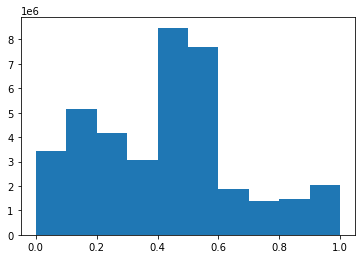

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(normalized.reshape((full_data.shape[0]*full_data.shape[1], full_data.shape[2]))[:, 0], 10)
plt.show()

In [25]:
full_data[np.where(full_data < -50.0)].shape

(2,)

In [66]:
dataset = tf.data.Dataset.from_tensor_slices(tf.math.tanh(tf.convert_to_tensor(normalized, dtype=tf.float32)))

In [67]:
dataset = dataset.cache()

In [68]:
for element in dataset:
    print(element)
    break

tf.Tensor(
[[0.46479085 0.4610453  0.758084  ]
 [0.46639103 0.459435   0.7615382 ]
 [0.46639103 0.45620537 0.7615382 ]
 [0.46479085 0.4610453  0.7615942 ]
 [0.46479085 0.45620537 0.7615942 ]
 [0.46479085 0.459435   0.7598164 ]
 [0.46318766 0.459435   0.7598164 ]
 [0.46318766 0.459435   0.7615382 ]
 [0.46318766 0.4610453  0.7615382 ]
 [0.46318766 0.459435   0.7615942 ]
 [0.46479085 0.4578217  0.7615942 ]
 [0.46211717 0.459435   0.7615382 ]
 [0.46639103 0.459435   0.7598164 ]
 [0.46479085 0.4578217  0.7615942 ]
 [0.46318766 0.45620537 0.7615382 ]
 [0.46211717 0.4610453  0.7615942 ]
 [0.46318766 0.4578217  0.7615382 ]
 [0.46211717 0.459435   0.7615942 ]
 [0.46479085 0.4578217  0.7606787 ]
 [0.46479085 0.459435   0.7615382 ]
 [0.46479085 0.46211717 0.7615382 ]
 [0.46479085 0.4578217  0.7615942 ]
 [0.46639103 0.4578217  0.7615942 ]
 [0.46479085 0.4610453  0.7615942 ]
 [0.46479085 0.459435   0.7615942 ]
 [0.46479085 0.4578217  0.7606787 ]
 [0.46318766 0.459435   0.7615942 ]
 [0.46211717 0.46

In [69]:
train_summary_writer = tf.summary.create_file_writer('log')
batches = dataset.shuffle(buffer_size=102400).batch(128)

In [70]:
for step, (x_train) in enumerate(batches):
    print(step, x_train.shape)
    pass

0 (128, 64, 3)
1 (128, 64, 3)
2 (128, 64, 3)
3 (128, 64, 3)
4 (128, 64, 3)
5 (128, 64, 3)
6 (128, 64, 3)
7 (128, 64, 3)
8 (128, 64, 3)
9 (128, 64, 3)
10 (128, 64, 3)
11 (128, 64, 3)
12 (128, 64, 3)
13 (128, 64, 3)
14 (128, 64, 3)
15 (128, 64, 3)
16 (128, 64, 3)
17 (128, 64, 3)
18 (128, 64, 3)
19 (128, 64, 3)
20 (128, 64, 3)
21 (128, 64, 3)
22 (128, 64, 3)
23 (128, 64, 3)
24 (128, 64, 3)
25 (128, 64, 3)
26 (128, 64, 3)
27 (128, 64, 3)
28 (128, 64, 3)
29 (128, 64, 3)
30 (128, 64, 3)
31 (128, 64, 3)
32 (128, 64, 3)
33 (128, 64, 3)
34 (128, 64, 3)
35 (128, 64, 3)
36 (128, 64, 3)
37 (128, 64, 3)
38 (128, 64, 3)
39 (128, 64, 3)
40 (128, 64, 3)
41 (128, 64, 3)
42 (128, 64, 3)
43 (128, 64, 3)
44 (128, 64, 3)
45 (128, 64, 3)
46 (128, 64, 3)
47 (128, 64, 3)
48 (128, 64, 3)
49 (128, 64, 3)
50 (128, 64, 3)
51 (128, 64, 3)
52 (128, 64, 3)
53 (128, 64, 3)
54 (128, 64, 3)
55 (128, 64, 3)
56 (128, 64, 3)
57 (128, 64, 3)
58 (128, 64, 3)
59 (128, 64, 3)
60 (128, 64, 3)
61 (128, 64, 3)
62 (128, 64, 3)
63

699 (128, 64, 3)
700 (128, 64, 3)
701 (128, 64, 3)
702 (128, 64, 3)
703 (128, 64, 3)
704 (128, 64, 3)
705 (128, 64, 3)
706 (128, 64, 3)
707 (128, 64, 3)
708 (128, 64, 3)
709 (128, 64, 3)
710 (128, 64, 3)
711 (128, 64, 3)
712 (128, 64, 3)
713 (128, 64, 3)
714 (128, 64, 3)
715 (128, 64, 3)
716 (128, 64, 3)
717 (128, 64, 3)
718 (128, 64, 3)
719 (128, 64, 3)
720 (128, 64, 3)
721 (128, 64, 3)
722 (128, 64, 3)
723 (128, 64, 3)
724 (128, 64, 3)
725 (128, 64, 3)
726 (128, 64, 3)
727 (128, 64, 3)
728 (128, 64, 3)
729 (128, 64, 3)
730 (128, 64, 3)
731 (128, 64, 3)
732 (128, 64, 3)
733 (128, 64, 3)
734 (128, 64, 3)
735 (128, 64, 3)
736 (128, 64, 3)
737 (128, 64, 3)
738 (128, 64, 3)
739 (128, 64, 3)
740 (128, 64, 3)
741 (128, 64, 3)
742 (128, 64, 3)
743 (128, 64, 3)
744 (128, 64, 3)
745 (128, 64, 3)
746 (128, 64, 3)
747 (128, 64, 3)
748 (128, 64, 3)
749 (128, 64, 3)
750 (128, 64, 3)
751 (128, 64, 3)
752 (128, 64, 3)
753 (128, 64, 3)
754 (128, 64, 3)
755 (128, 64, 3)
756 (128, 64, 3)
757 (128, 64, 

1410 (128, 64, 3)
1411 (128, 64, 3)
1412 (128, 64, 3)
1413 (128, 64, 3)
1414 (128, 64, 3)
1415 (128, 64, 3)
1416 (128, 64, 3)
1417 (128, 64, 3)
1418 (128, 64, 3)
1419 (128, 64, 3)
1420 (128, 64, 3)
1421 (128, 64, 3)
1422 (128, 64, 3)
1423 (128, 64, 3)
1424 (128, 64, 3)
1425 (128, 64, 3)
1426 (128, 64, 3)
1427 (128, 64, 3)
1428 (128, 64, 3)
1429 (128, 64, 3)
1430 (128, 64, 3)
1431 (128, 64, 3)
1432 (128, 64, 3)
1433 (128, 64, 3)
1434 (128, 64, 3)
1435 (128, 64, 3)
1436 (128, 64, 3)
1437 (128, 64, 3)
1438 (128, 64, 3)
1439 (128, 64, 3)
1440 (128, 64, 3)
1441 (128, 64, 3)
1442 (128, 64, 3)
1443 (128, 64, 3)
1444 (128, 64, 3)
1445 (128, 64, 3)
1446 (128, 64, 3)
1447 (128, 64, 3)
1448 (128, 64, 3)
1449 (128, 64, 3)
1450 (128, 64, 3)
1451 (128, 64, 3)
1452 (128, 64, 3)
1453 (128, 64, 3)
1454 (128, 64, 3)
1455 (128, 64, 3)
1456 (128, 64, 3)
1457 (128, 64, 3)
1458 (128, 64, 3)
1459 (128, 64, 3)
1460 (128, 64, 3)
1461 (128, 64, 3)
1462 (128, 64, 3)
1463 (128, 64, 3)
1464 (128, 64, 3)
1465 (128,

2026 (128, 64, 3)
2027 (128, 64, 3)
2028 (128, 64, 3)
2029 (128, 64, 3)
2030 (128, 64, 3)
2031 (128, 64, 3)
2032 (128, 64, 3)
2033 (128, 64, 3)
2034 (128, 64, 3)
2035 (128, 64, 3)
2036 (128, 64, 3)
2037 (128, 64, 3)
2038 (128, 64, 3)
2039 (128, 64, 3)
2040 (128, 64, 3)
2041 (128, 64, 3)
2042 (128, 64, 3)
2043 (128, 64, 3)
2044 (128, 64, 3)
2045 (128, 64, 3)
2046 (128, 64, 3)
2047 (128, 64, 3)
2048 (128, 64, 3)
2049 (128, 64, 3)
2050 (128, 64, 3)
2051 (128, 64, 3)
2052 (128, 64, 3)
2053 (128, 64, 3)
2054 (128, 64, 3)
2055 (128, 64, 3)
2056 (128, 64, 3)
2057 (128, 64, 3)
2058 (128, 64, 3)
2059 (128, 64, 3)
2060 (128, 64, 3)
2061 (128, 64, 3)
2062 (128, 64, 3)
2063 (128, 64, 3)
2064 (128, 64, 3)
2065 (128, 64, 3)
2066 (128, 64, 3)
2067 (128, 64, 3)
2068 (128, 64, 3)
2069 (128, 64, 3)
2070 (128, 64, 3)
2071 (128, 64, 3)
2072 (128, 64, 3)
2073 (128, 64, 3)
2074 (128, 64, 3)
2075 (128, 64, 3)
2076 (128, 64, 3)
2077 (128, 64, 3)
2078 (128, 64, 3)
2079 (128, 64, 3)
2080 (128, 64, 3)
2081 (128,

2631 (128, 64, 3)
2632 (128, 64, 3)
2633 (128, 64, 3)
2634 (128, 64, 3)
2635 (128, 64, 3)
2636 (128, 64, 3)
2637 (128, 64, 3)
2638 (128, 64, 3)
2639 (128, 64, 3)
2640 (128, 64, 3)
2641 (128, 64, 3)
2642 (128, 64, 3)
2643 (128, 64, 3)
2644 (128, 64, 3)
2645 (128, 64, 3)
2646 (128, 64, 3)
2647 (128, 64, 3)
2648 (128, 64, 3)
2649 (128, 64, 3)
2650 (128, 64, 3)
2651 (128, 64, 3)
2652 (128, 64, 3)
2653 (128, 64, 3)
2654 (128, 64, 3)
2655 (128, 64, 3)
2656 (128, 64, 3)
2657 (128, 64, 3)
2658 (128, 64, 3)
2659 (128, 64, 3)
2660 (128, 64, 3)
2661 (128, 64, 3)
2662 (128, 64, 3)
2663 (128, 64, 3)
2664 (128, 64, 3)
2665 (128, 64, 3)
2666 (128, 64, 3)
2667 (128, 64, 3)
2668 (128, 64, 3)
2669 (128, 64, 3)
2670 (128, 64, 3)
2671 (128, 64, 3)
2672 (128, 64, 3)
2673 (128, 64, 3)
2674 (128, 64, 3)
2675 (128, 64, 3)
2676 (128, 64, 3)
2677 (128, 64, 3)
2678 (128, 64, 3)
2679 (128, 64, 3)
2680 (128, 64, 3)
2681 (128, 64, 3)
2682 (128, 64, 3)
2683 (128, 64, 3)
2684 (128, 64, 3)
2685 (128, 64, 3)
2686 (128,

3223 (128, 64, 3)
3224 (128, 64, 3)
3225 (128, 64, 3)
3226 (128, 64, 3)
3227 (128, 64, 3)
3228 (128, 64, 3)
3229 (128, 64, 3)
3230 (128, 64, 3)
3231 (128, 64, 3)
3232 (128, 64, 3)
3233 (128, 64, 3)
3234 (128, 64, 3)
3235 (128, 64, 3)
3236 (128, 64, 3)
3237 (128, 64, 3)
3238 (128, 64, 3)
3239 (128, 64, 3)
3240 (128, 64, 3)
3241 (128, 64, 3)
3242 (128, 64, 3)
3243 (128, 64, 3)
3244 (128, 64, 3)
3245 (128, 64, 3)
3246 (128, 64, 3)
3247 (128, 64, 3)
3248 (128, 64, 3)
3249 (128, 64, 3)
3250 (128, 64, 3)
3251 (128, 64, 3)
3252 (128, 64, 3)
3253 (128, 64, 3)
3254 (128, 64, 3)
3255 (128, 64, 3)
3256 (128, 64, 3)
3257 (128, 64, 3)
3258 (128, 64, 3)
3259 (128, 64, 3)
3260 (128, 64, 3)
3261 (128, 64, 3)
3262 (128, 64, 3)
3263 (128, 64, 3)
3264 (128, 64, 3)
3265 (128, 64, 3)
3266 (128, 64, 3)
3267 (128, 64, 3)
3268 (128, 64, 3)
3269 (128, 64, 3)
3270 (128, 64, 3)
3271 (128, 64, 3)
3272 (128, 64, 3)
3273 (128, 64, 3)
3274 (128, 64, 3)
3275 (128, 64, 3)
3276 (128, 64, 3)
3277 (128, 64, 3)
3278 (128,

3825 (128, 64, 3)
3826 (128, 64, 3)
3827 (128, 64, 3)
3828 (128, 64, 3)
3829 (128, 64, 3)
3830 (128, 64, 3)
3831 (128, 64, 3)
3832 (128, 64, 3)
3833 (128, 64, 3)
3834 (128, 64, 3)
3835 (128, 64, 3)
3836 (128, 64, 3)
3837 (128, 64, 3)
3838 (128, 64, 3)
3839 (128, 64, 3)
3840 (128, 64, 3)
3841 (128, 64, 3)
3842 (128, 64, 3)
3843 (128, 64, 3)
3844 (128, 64, 3)
3845 (128, 64, 3)
3846 (128, 64, 3)
3847 (128, 64, 3)
3848 (128, 64, 3)
3849 (128, 64, 3)
3850 (128, 64, 3)
3851 (128, 64, 3)
3852 (128, 64, 3)
3853 (128, 64, 3)
3854 (128, 64, 3)
3855 (128, 64, 3)
3856 (128, 64, 3)
3857 (128, 64, 3)
3858 (128, 64, 3)
3859 (128, 64, 3)
3860 (128, 64, 3)
3861 (128, 64, 3)
3862 (128, 64, 3)
3863 (128, 64, 3)
3864 (128, 64, 3)
3865 (128, 64, 3)
3866 (128, 64, 3)
3867 (128, 64, 3)
3868 (128, 64, 3)
3869 (128, 64, 3)
3870 (128, 64, 3)
3871 (128, 64, 3)
3872 (128, 64, 3)
3873 (128, 64, 3)
3874 (128, 64, 3)
3875 (128, 64, 3)
3876 (128, 64, 3)
3877 (128, 64, 3)
3878 (128, 64, 3)
3879 (128, 64, 3)
3880 (128,

4482 (128, 64, 3)
4483 (128, 64, 3)
4484 (128, 64, 3)
4485 (128, 64, 3)
4486 (128, 64, 3)
4487 (128, 64, 3)
4488 (128, 64, 3)
4489 (128, 64, 3)
4490 (128, 64, 3)
4491 (128, 64, 3)
4492 (128, 64, 3)
4493 (128, 64, 3)
4494 (128, 64, 3)
4495 (128, 64, 3)
4496 (128, 64, 3)
4497 (128, 64, 3)
4498 (128, 64, 3)
4499 (128, 64, 3)
4500 (128, 64, 3)
4501 (128, 64, 3)
4502 (128, 64, 3)
4503 (128, 64, 3)
4504 (128, 64, 3)
4505 (128, 64, 3)
4506 (128, 64, 3)
4507 (128, 64, 3)
4508 (128, 64, 3)
4509 (128, 64, 3)
4510 (128, 64, 3)
4511 (128, 64, 3)
4512 (128, 64, 3)
4513 (128, 64, 3)
4514 (128, 64, 3)
4515 (128, 64, 3)
4516 (128, 64, 3)
4517 (128, 64, 3)
4518 (128, 64, 3)
4519 (128, 64, 3)
4520 (128, 64, 3)
4521 (128, 64, 3)
4522 (128, 64, 3)
4523 (128, 64, 3)
4524 (128, 64, 3)
4525 (128, 64, 3)
4526 (128, 64, 3)
4527 (128, 64, 3)
4528 (128, 64, 3)
4529 (128, 64, 3)
4530 (128, 64, 3)
4531 (128, 64, 3)
4532 (128, 64, 3)
4533 (128, 64, 3)
4534 (128, 64, 3)
4535 (128, 64, 3)
4536 (128, 64, 3)
4537 (128,

In [71]:
total_step = 0

In [421]:
epochs = 0
for epoch in range(epochs):
    print(f'starting epoch {epoch}\n')
    epoch_loss = []
    for step, (x_train) in enumerate(batches):
        with tf.GradientTape() as tape:
            outputs = autoencoder(x_train, training=True)
            loss = tf.reduce_mean(tf.square(x_train - outputs))
            
        grads = tape.gradient(loss, autoencoder.trainable_weights)
        optimizer.apply_gradients(zip(grads, autoencoder.trainable_weights))
        
        epoch_loss.append(float(loss.numpy()))
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.numpy(), step=total_step)
            total_step += 1
        if step % 100 == 0:
            print(f'epoch {epoch}, step {step}, training loss: {loss.numpy()}')

    print(f'\nepoch {epoch}, epoch_loss: {np.mean(epoch_loss)}')

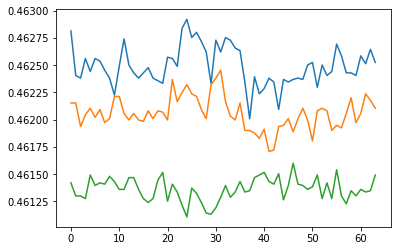

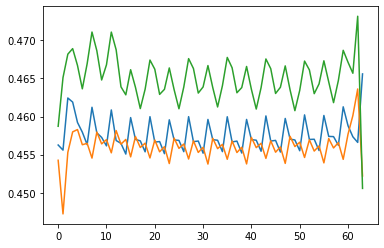

0.0050407154

In [73]:
inputs = next(iter(dataset.batch(10000)))[6500]
inputs = np.asarray([inputs])
outputs = autoencoder(inputs)
inputs = inputs[0]
outputs = outputs[0]

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(inputs)
plt.show()
plt.plot(outputs)
plt.show()
np.mean(tf.keras.losses.MAE(inputs, outputs))

In [74]:
autoencoder.save_weights('autoencoder_v2.h5')

In [75]:
autoencoder.encoder(np.asarray([inputs]))

<tf.Tensor: shape=(1, 8, 8), dtype=float32, numpy=
array([[[  0.     , 647.74866, 501.793  ,   0.     ,   0.     ,
         459.57297,   0.     ,   0.     ],
        [  0.     , 688.1772 , 475.31613,   0.     ,   0.     ,
         446.1841 ,   0.     ,   0.     ],
        [  0.     , 685.39813, 474.0936 ,   0.     ,   0.     ,
         446.18466,   0.     ,   0.     ],
        [  0.     , 685.57416, 474.03915,   0.     ,   0.     ,
         446.42914,   0.     ,   0.     ],
        [  0.     , 685.3912 , 474.03506,   0.     ,   0.     ,
         446.08368,   0.     ,   0.     ],
        [  0.     , 685.56903, 473.61667,   0.     ,   0.     ,
         446.3205 ,   0.     ,   0.     ],
        [  0.     , 681.1917 , 473.07172,   0.     ,   0.     ,
         446.32248,   0.     ,   0.     ],
        [  0.     , 626.39703, 510.8068 ,   0.     ,   0.     ,
         374.5116 ,   0.     ,   0.     ]]], dtype=float32)>

In [118]:
if 0:
    for df in dfs:
        import matplotlib.pyplot as plt
        %matplotlib inline
        plt.plot(df.iloc[:, 1:4])
        plt.title(df.iloc[:, 0][0])
        plt.show()

In [96]:
np.asarray(dfs[0].iloc[:, 0][0])

array([['Walking'],
       ['Walking'],
       ['Walking'],
       ...,
       ['Walking'],
       ['Walking'],
       ['Walking']], dtype=object)

In [111]:
len(dfs)

710

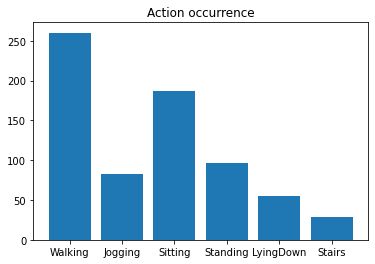

In [136]:
from collections import defaultdict
occur = defaultdict(lambda:0)
for df in dfs:
    act = df.iloc[:, 0][0]
    occur[act] += 1
    #print(act)
#print(occurance)
plt.title('Action occurrence')
plt.bar(occur.keys(), occur.values())
plt.show()

In [141]:
wins = df_to_windows(dfs[0])
len(wins), wins

(16,
 [array([[ 0.2941316 , -0.6356053 , -0.22693644],
         [-0.49968776, -0.6044512 , -0.22602014],
         [-2.1783454 ,  0.7134906 ,  0.37201694],
         [-2.7977629 ,  1.3548992 , -0.27763826],
         [-2.1679606 , -1.3277156 , -0.5549711 ],
         [-1.7348573 ,  0.8185594 , -0.16554448],
         [-1.4639386 ,  0.8359691 ,  0.4111123 ],
         [-0.9450085 ,  1.0852021 ,  0.39522982],
         [ 0.18203785,  0.28130344,  0.5342017 ],
         [ 0.9483683 ,  0.07849618,  0.5647449 ],
         [ 1.6756034 , -0.8579602 ,  0.66889745],
         [ 1.4010195 , -1.3286319 ,  0.4465425 ],
         [-1.162782  ,  0.9315695 , -0.09621128],
         [-0.2846632 ,  0.19700404, -0.47158796],
         [-0.3200934 , -1.6398678 , -0.07147124],
         [ 1.3130548 , -1.5134187 , -0.6954701 ],
         [ 1.6978999 , -2.1248949 , -0.11911872],
         [ 1.7724255 , -1.6646078 , -0.43463063],
         [ 2.3289237 , -2.6535985 ,  0.1301143 ],
         [ 1.5464053 , -1.754405  ,  0.028099

In [397]:
data = []
occur.keys()

acts = ['Walking', 'Jogging', 'Sitting', 'Standing', 'LyingDown', 'Stairs']
encoding = np.asarray(tf.one_hot(range(len(acts)), len(acts)))

In [398]:
encoding

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [399]:
cache_path = 'windowed_labeled.pkl'
if os.path.isfile(cache_path):
    print(f'loading {cache_path}')
    with open(cache_path, 'rb') as file:
        cached = pickle.load(file)
else:
    print(f'writing {cache_path}')
    labels = []
    data = []
    for df in dfs:
        df = df.dropna()
        act = df[1][0]
        act = encoding[acts.index(act)]
        for feature in df_to_windows(df):
            if len(feature) != time_step:
                continue
            data.append(feature)
            labels.append(act)

    data = np.asarray(data, dtype=np.float32)
    labels = np.asarray(labels, dtype=np.float32)
    cached = (data, labels)
    
    with open(cache_path, 'wb') as file:
        pickle.dump(cached, file)
        
data, labels = cached

loading windowed_labeled.pkl


In [400]:
dfs[0]

,1,2,3,4
0,,,,
2013-06-06 12:07:49.550,Walking,0.294132,-0.635605,-0.226936
2013-06-06 12:07:49.600,Walking,-0.499688,-0.604451,-0.226020
2013-06-06 12:07:49.650,Walking,-2.178345,0.713491,0.372017
2013-06-06 12:07:49.700,Walking,-2.797763,1.354899,-0.277638
2013-06-06 12:07:49.750,Walking,-2.167961,-1.327716,-0.554971
...,...,...,...,...
2013-06-06 12:08:39.500,Walking,-1.808772,1.565953,1.091922
2013-06-06 12:08:39.550,Walking,-0.178678,1.257772,1.084286
2013-06-06 12:08:39.600,Walking,0.866818,0.437379,0.545808


In [401]:
labels[0], data[0]

(array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.2941316 , -0.6356053 , -0.22693644],
        [-0.49968776, -0.6044512 , -0.22602014],
        [-2.1783454 ,  0.7134906 ,  0.37201694],
        [-2.7977629 ,  1.3548992 , -0.27763826],
        [-2.1679606 , -1.3277156 , -0.5549711 ],
        [-1.7348573 ,  0.8185594 , -0.16554448],
        [-1.4639386 ,  0.8359691 ,  0.4111123 ],
        [-0.9450085 ,  1.0852021 ,  0.39522982],
        [ 0.18203785,  0.28130344,  0.5342017 ],
        [ 0.9483683 ,  0.07849618,  0.5647449 ],
        [ 1.6756034 , -0.8579602 ,  0.66889745],
        [ 1.4010195 , -1.3286319 ,  0.4465425 ],
        [-1.162782  ,  0.9315695 , -0.09621128],
        [-0.2846632 ,  0.19700404, -0.47158796],
        [-0.3200934 , -1.6398678 , -0.07147124],
        [ 1.3130548 , -1.5134187 , -0.6954701 ],
        [ 1.6978999 , -2.1248949 , -0.11911872],
        [ 1.7724255 , -1.6646078 , -0.43463063],
        [ 2.3289237 , -2.6535985 ,  0.1301143 ],
        [ 1.5464053 

In [402]:
data.shape, labels.shape

((45552, 64, 3), (45552, 6))

In [403]:
np.mean(data), np.min(data), np.max(data), np.std(data)

(1.2219912, -52.60287, 80.13994, 6.106334)

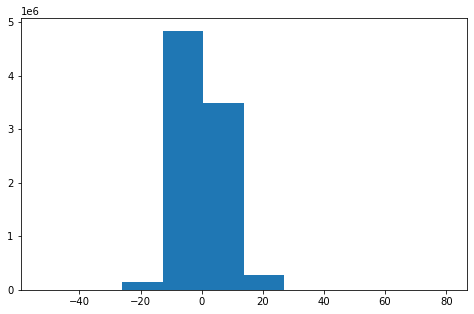

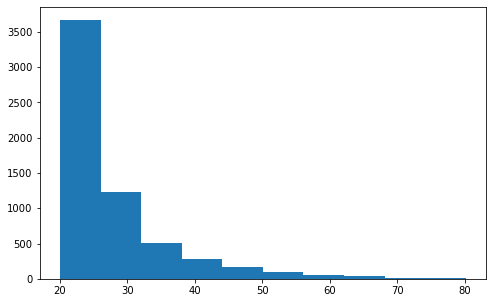

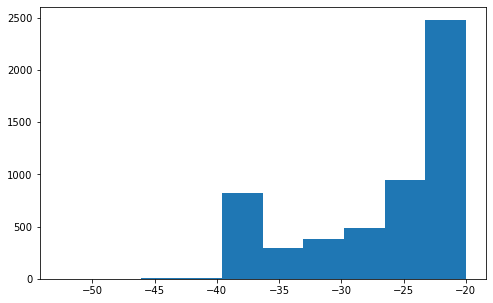

In [404]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.hist(data.flatten())
plt.show()
plt.hist(data.flatten()[np.where(data.flatten() > 20)])
plt.show()
plt.hist(data.flatten()[np.where(data.flatten() < -20)])
plt.show()

In [405]:
from sklearn.model_selection import train_test_split

In [406]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1234)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31886, 64, 3), (31886, 6), (13666, 64, 3), (13666, 6))

In [407]:
encoding[3]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

In [408]:
def standardize(x):
    return x

def normalize(x):
    return x

In [409]:
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Dense

class HAR(Model):
    def __init__(self):
        super().__init__()
        self.conv = Sequential([
            InputLayer(input_shape), 
            Conv1D(32, 3, activation='relu', padding='same', strides=1),
            Conv1D(32, 3, activation='relu', padding='same', strides=1),
            BatchNormalization(),
            MaxPooling1D(),
            Conv1D(16, 3, activation='relu', padding='same', strides=1),
            Conv1D(16, 3, activation='relu', padding='same', strides=1),
            GlobalAveragePooling1D(),
        ])
        self.fcn = Sequential([
            Dense(100, activation='relu'),
            Dense(len(acts), activation='softmax'),
        ])
        
        
    @tf.function
    def call(self, x):
        x = self.conv(x)
        x = self.fcn(x)
        return x

In [410]:
model = HAR()

In [411]:
model(x_train[:1])
model.conv.summary()
model.fcn.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 64, 32)            320       
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 64, 32)            3104      
_________________________________________________________________
batch_normalization_28 (Batc (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 32, 16)            1552      
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 32, 16)            784       
_________________________________________________________________
global_average_pooling1d_18  (None, 16)              

In [412]:
model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [413]:
from datetime import datetime
logdir = os.path.join('log', datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/100
200/200 [==============================] - 5s 21ms/step - loss: 1.0107 - accuracy: 0.6126 - val_loss: 0.5293 - val_accuracy: 0.7965
Epoch 2/100
200/200 [==============================] - 3s 17ms/step - loss: 0.5081 - accuracy: 0.8016 - val_loss: 0.4746 - val_accuracy: 0.8195
Epoch 3/100
200/200 [==============================] - 4s 18ms/step - loss: 0.4609 - accuracy: 0.8179 - val_loss: 0.4309 - val_accuracy: 0.8311
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 0.4262 - accuracy: 0.8354 - val_loss: 0.4155 - val_accuracy: 0.8388
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 0.3995 - accuracy: 0.8416 - val_loss: 0.3946 - val_accuracy: 0.8448
Epoch 6/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3860 - accuracy: 0.8445 - val_loss: 0.3906 - val_accuracy: 0.8401
Epoch 7/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3670 - accuracy: 0.8580 - val_loss: 0.3547 - val_accuracy:

In [414]:
model.evaluate(x_test, y_test)

428/428 [==============================] - 1s 2ms/step - loss: 0.2456 - accuracy: 0.9188


[0.24563054740428925, 0.9187765121459961]

In [415]:
acts[np.argmax(model(x_train[:1]))], acts[np.argmax(y_train[:1])]

('Walking', 'Walking')

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[13948,     5,    84,    88,    12,     5],
       [   20,  4053,    14,     9,     0,     3],
       [   66,     1,  6259,   172,   254,     6],
       [   58,     0,   518,  2465,    35,     3],
       [   21,     1,   375,    12,  2752,     0],
       [   40,     3,     9,     6,     0,   589]])>

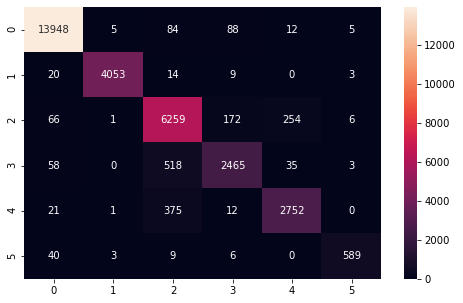

In [420]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
cm = tf.math.confusion_matrix(y_train.argmax(axis=1), np.argmax(model(x_train), axis=1))
sn.heatmap(cm, annot=True, fmt='d')
cm

In [417]:
y = y_train.argmax(axis=1)
y[np.where(y == 3)].shape

(3079,)

In [418]:
np.sum(cm[3])

3079